In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange

import matplotlib.gridspec as gridspec


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

torch.Size([3, 750, 1061])


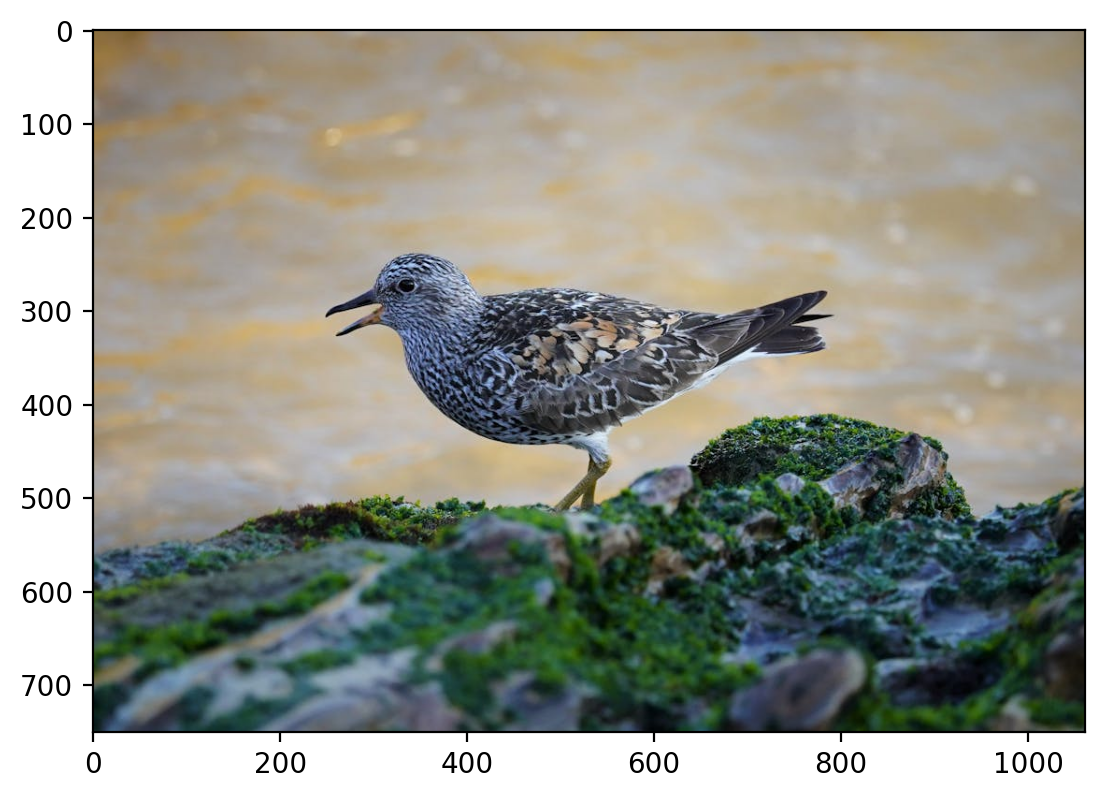

In [2]:
img = torchvision.io.read_image("image.jpeg")
# img = data.astronaut()
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
plt.show()

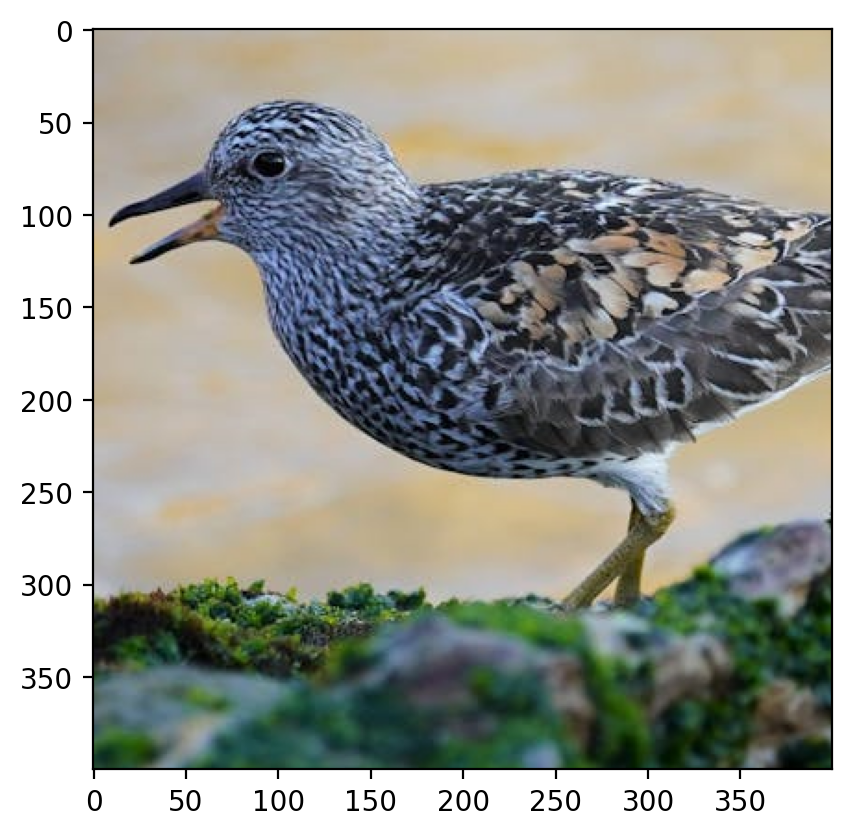

In [3]:
crop = torchvision.transforms.functional.crop(img, 200,240, 400, 400)
plt.imshow(crop.permute(1,2,0))

In [4]:
crop.shape


torch.Size([3, 400, 400])

In [5]:
crop.type

<function Tensor.type>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def factorize(A, r, device=torch.device("cpu")):

    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W,H)-A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

Rank is 50
Losses  are (R,G,B) = (4656.041015625,4707.1435546875,4827.1640625) 
loss sum: (tensor(9363.1846, grad_fn=<AddBackward0>), tensor(4827.1641, grad_fn=<LinalgVectorNormBackward0>))


TypeError: Invalid shape (3, 400, 400) for image data

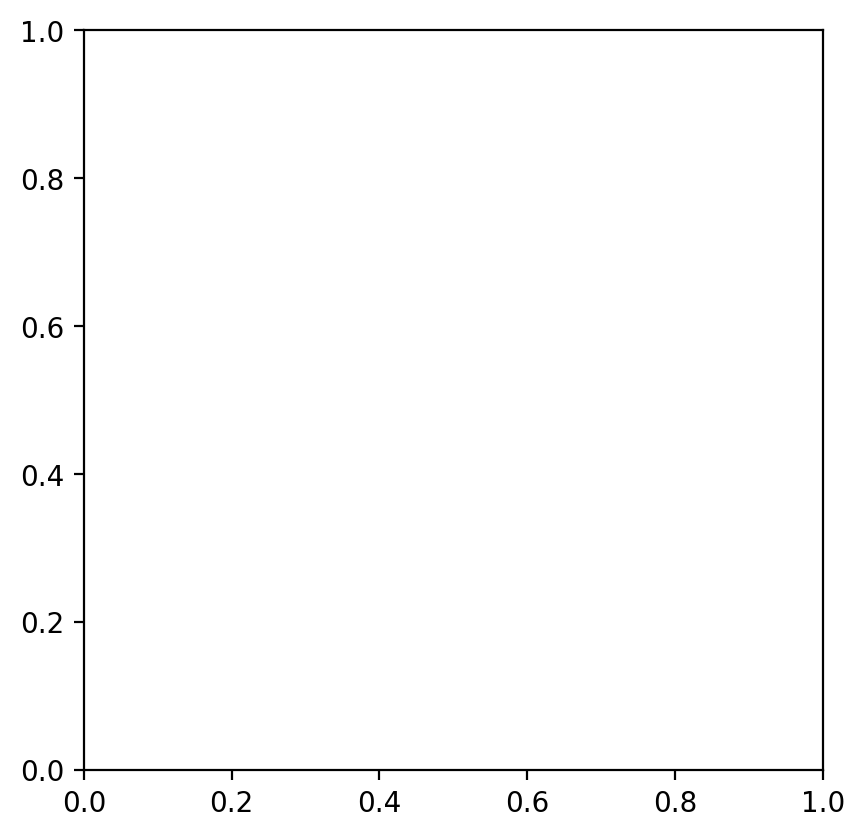

In [7]:

for rank in range(50,300,100):
    rank = 50
    R = crop[0, :, :]  # Red channel
    G = crop[1, :, :]  # Green channel
    B = crop[2, :, :]  # Blue channel

    U_R, V_R, loss_R = factorize(R, rank)
    U_G, V_G, loss_G = factorize(G, rank)
    U_B, V_B, loss_B = factorize(B, rank)

    # Reconstruct the channels
    R_reconst = np.dot(U_R.detach().numpy(), V_R.detach().numpy())
    G_reconst = np.dot(U_G.detach().numpy(), V_G.detach().numpy())
    B_reconst = np.dot(U_B.detach().numpy(), V_B.detach().numpy())

    # Stack the channels back into a color image
    img_reconst = np.stack([R_reconst, G_reconst, B_reconst], axis=2).astype(np.uint8)
    img_reconst = torch.tensor(img_reconst, dtype=torch.uint8)


    img_reconst= [R_reconst, G_reconst, B_reconst]
    print(f"Rank is {rank}")
    print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
    print(f"loss sum: {loss_R + loss_G, loss_B}")
    plt.imshow(img_reconst)
    plt.show()


In [58]:
# img_reconst = np.stack([R_reconst, G_reconst, B_reconst], axis=2).astype(np.uint8)
# img_reconst = torch.tensor(img_reconst, dtype=torch.uint8)

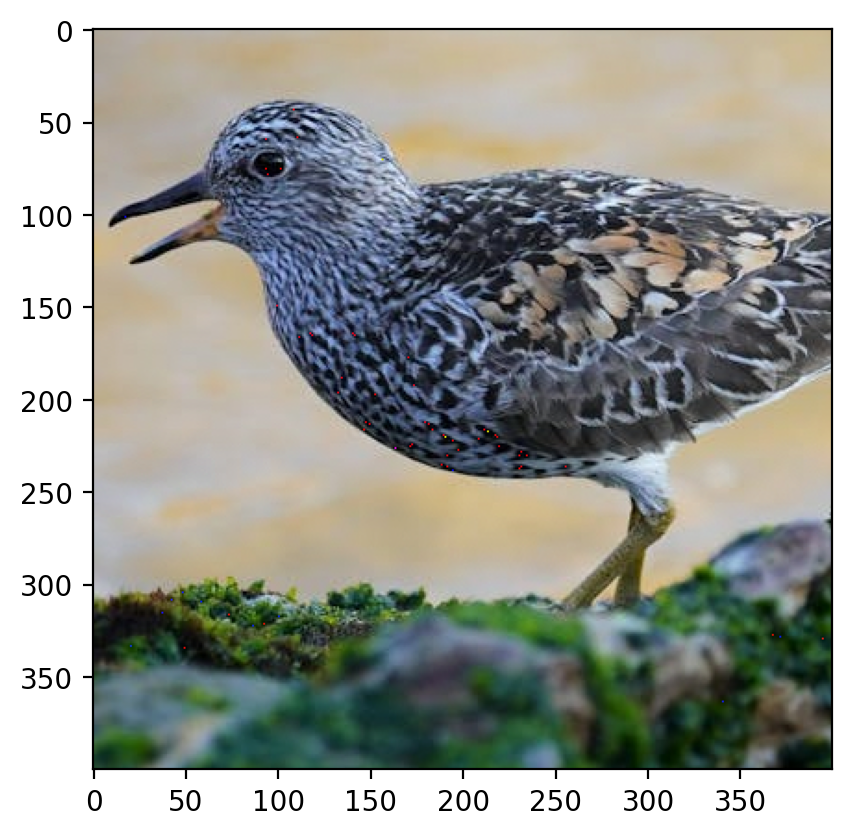

In [61]:
# plt.imshow(img_reconst)

In [43]:
print(f"Rank is {rank}")
print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
print(f"loss sum: {loss_R + loss_G, loss_B}")
plt.imshow(img_reconst)
plt.show()

Rank is 250
Losses  are (R,G,B) = (228.4221649169922,223.61871337890625,229.4617156982422) 
loss sum: (tensor(452.0409, grad_fn=<AddBackward0>), tensor(229.4617, grad_fn=<LinalgVectorNormBackward0>))


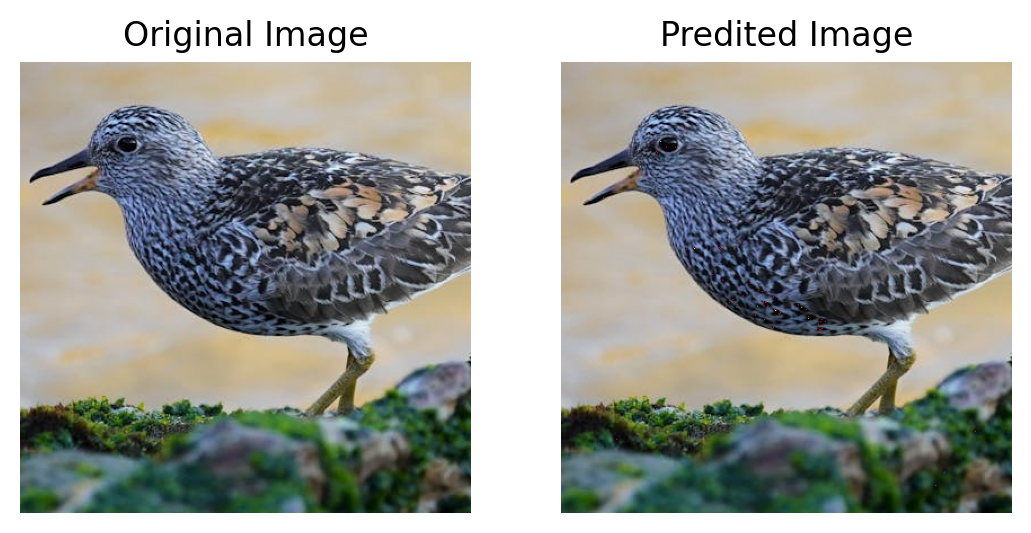

In [44]:
# pred_img = torch.mm(W,H).cpu().detach().numpy()
# plt.figure(figsize=(100,300))
plt.subplot(1,2,1)
plt.imshow(crop.permute(1,2,0))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_reconst)
plt.title("Predited Image")
plt.axis("off")
plt.show()


In [3]:

def rmse_psnr(org, pred):
    if isinstance(org, np.ndarray):
        org = torch.from_numpy(org)
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred)
    squared_diff = (org.float() - pred.float()) ** 2

    mse = torch.mean(squared_diff)
    rmse = torch.sqrt(mse)    
    
    max_pixel_value = 255.0

    psnr = 20 * np.log10(max_pixel_value / rmse)
    
    return rmse, psnr


RMSE and PSNR values

In [66]:

rmse,psnr = rmse_psnr(crop.permute(1,2,0),img_reconst)
print(f"rmse: {rmse} , psnr: {psnr}")

rmse: 3.0708446502685547 , psnr: 38.38564682006836


# Question 2

In [5]:
img2 = torchvision.io.read_image("image.jpeg")
print(img2.shape)

torch.Size([3, 750, 1061])


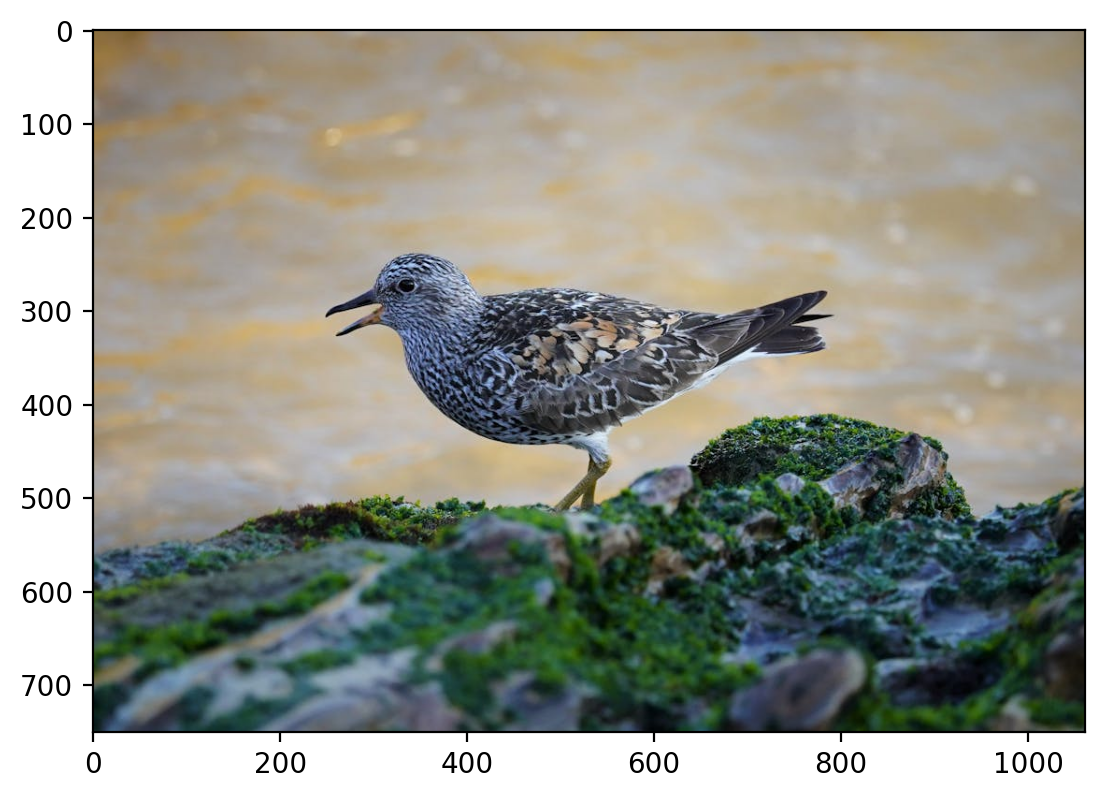

In [6]:
plt.imshow(img2.permute(1,2,0))

torch.Size([3, 200, 200])

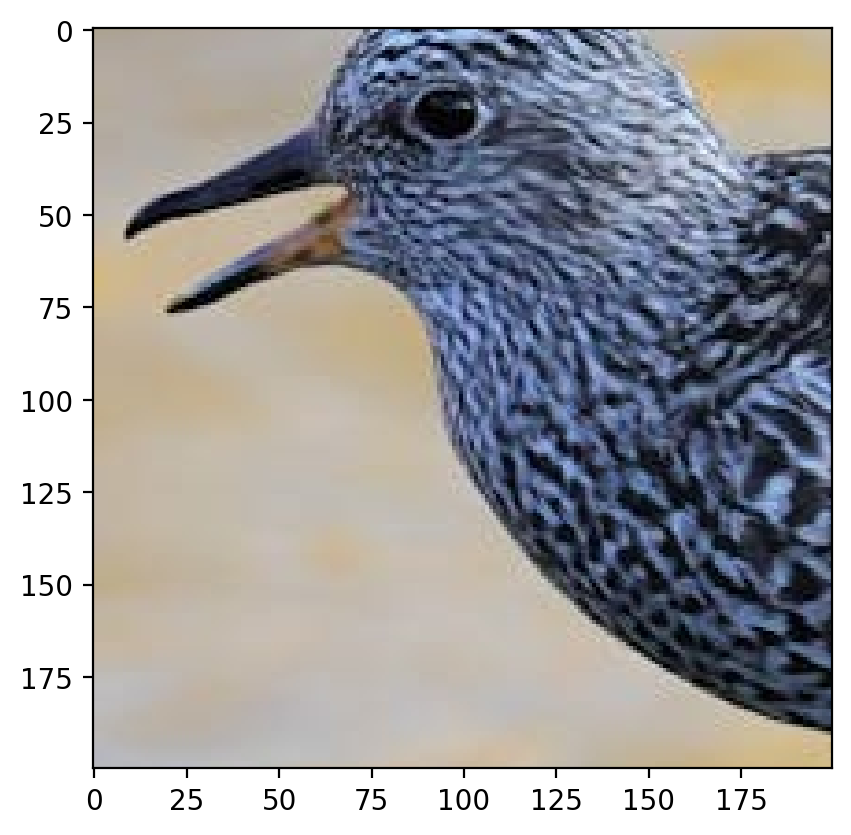

In [7]:
c_img = torchvision.transforms.functional.crop(img2, 250,240, 200, 200)
plt.imshow(c_img.permute(1,2,0))
c_img.shape

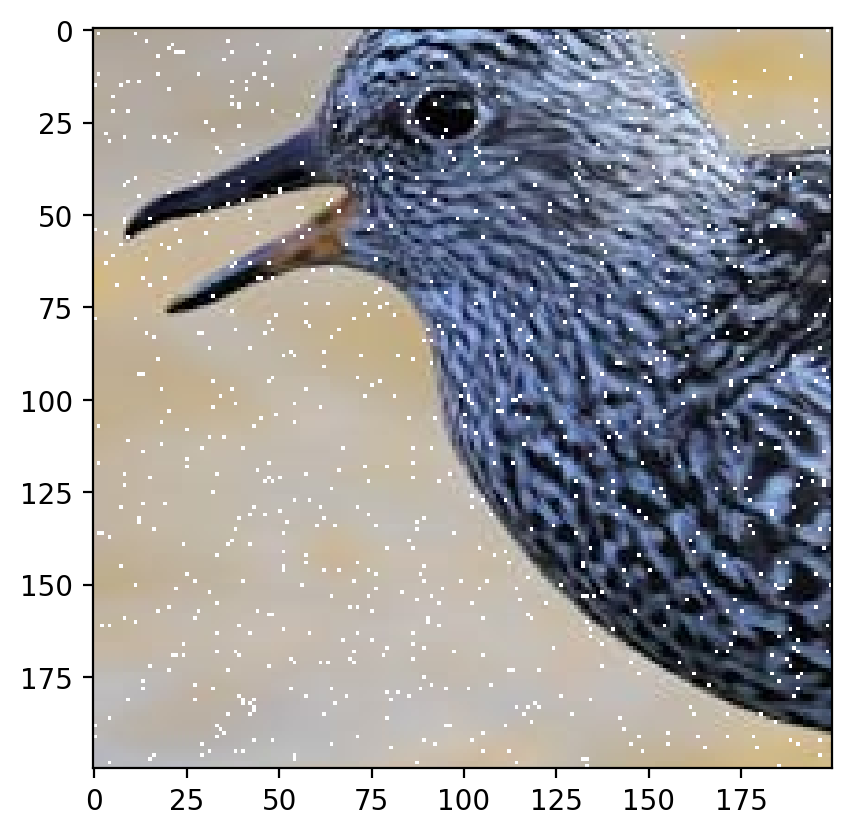

In [8]:
def img_pix_rm(i_img, num_pixels):
    # Get the dimensions of the image
    img = i_img.clone().float()
    _, height, width = img.shape  # shape: (channels, height, width)

    # Ensure num_pixels doesn't exceed the total number of pixels
    total_pixels = height * width
    num_pixels = min(num_pixels, total_pixels)
    
    # Generate random pixel indices
    pixels_to_remove = torch.randperm(total_pixels)[:num_pixels]
    
    # Convert 1D indices to 2D indices (height, width)
    row_indices = pixels_to_remove // width
    col_indices = pixels_to_remove % width

    # For each channel, set the selected pixel locations to zero (or any other value)
    for channel in range(3):
        img[channel, row_indices, col_indices] = float('nan')
    
    return img

m_img = img_pix_rm(c_img,900)
# m_img
plt.imshow(m_img.permute(1, 2, 0).cpu().numpy() / 255)

Rank is 50
Losses  are (R,G,B) = (1665.5577392578125,1666.637939453125,1709.2520751953125) 
loss sum: (tensor(3332.1958, grad_fn=<AddBackward0>), tensor(1709.2521, grad_fn=<LinalgVectorNormBackward0>))


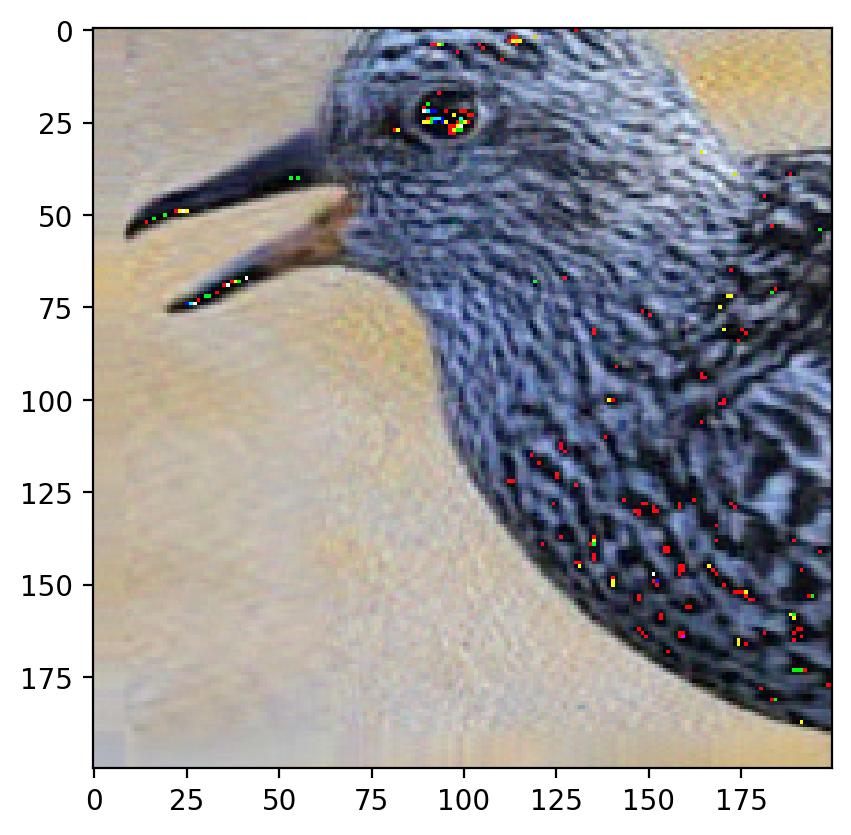

Rank is 150
Losses  are (R,G,B) = (62.88957214355469,59.6054801940918,62.56930923461914) 
loss sum: (tensor(122.4951, grad_fn=<AddBackward0>), tensor(62.5693, grad_fn=<LinalgVectorNormBackward0>))


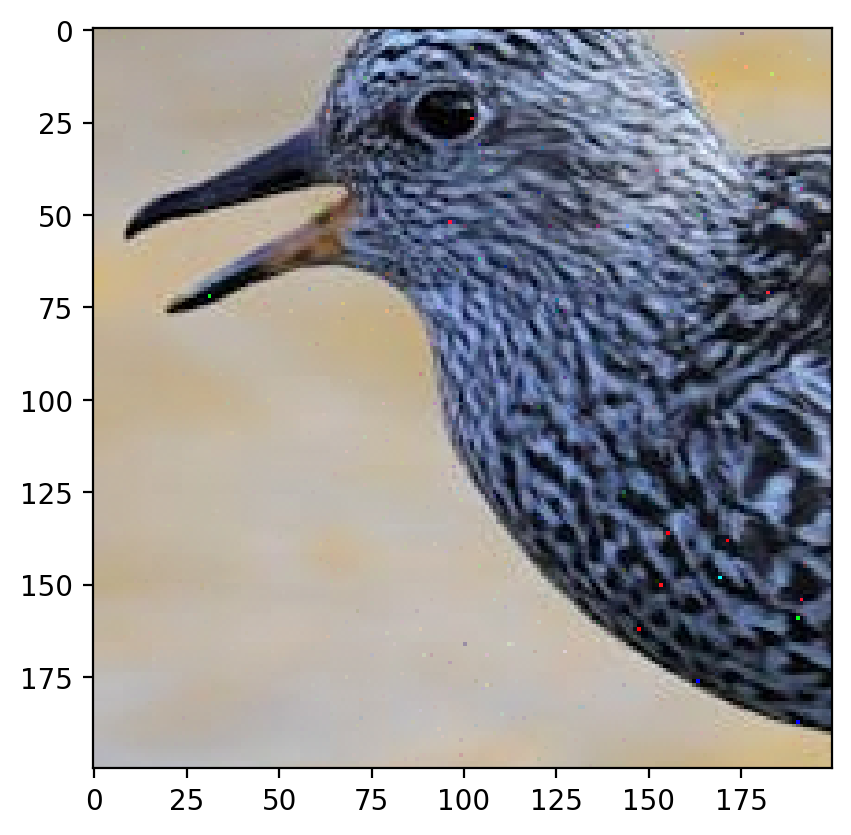

Rank is 250
Losses  are (R,G,B) = (22.361045837402344,37.83519744873047,51.6325798034668) 
loss sum: (tensor(60.1962, grad_fn=<AddBackward0>), tensor(51.6326, grad_fn=<LinalgVectorNormBackward0>))


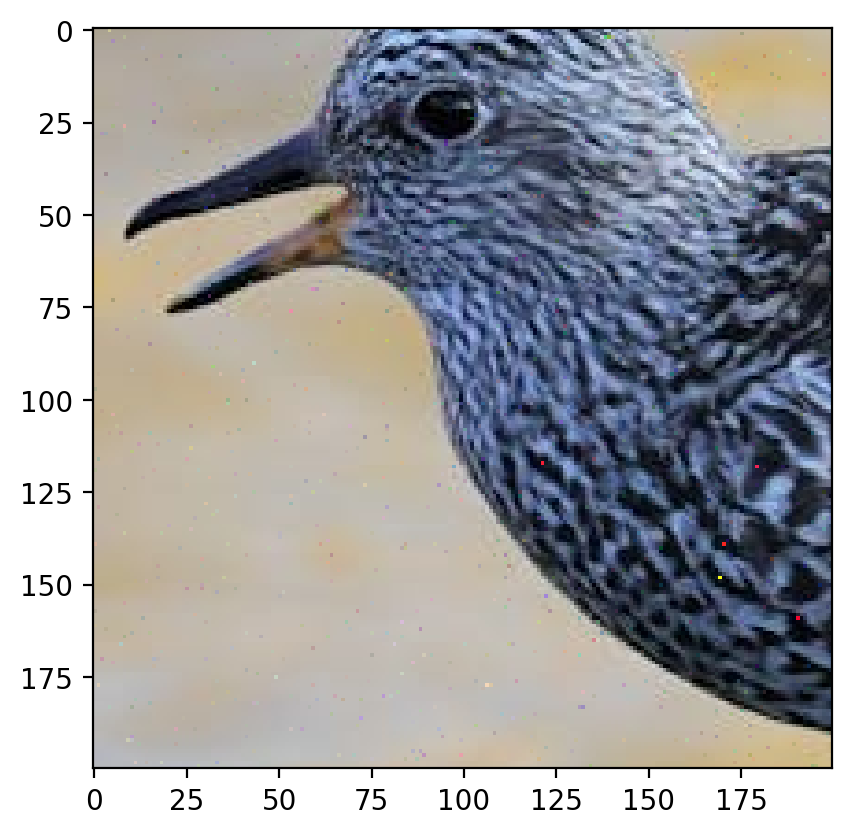

In [9]:
for rank in range(50,300,100):
# rank = 50
    R = m_img[0, :, :]
    G = m_img[1, :, :]
    B = m_img[2, :, :]

    U_R, V_R, loss_R = factorize(R, rank)
    U_G, V_G, loss_G = factorize(G, rank)
    U_B, V_B, loss_B = factorize(B, rank)

    # Reconstruct the channels
    R_rc = np.dot(U_R.detach().numpy(), V_R.detach().numpy())
    G_rc = np.dot(U_G.detach().numpy(), V_G.detach().numpy())
    B_rc = np.dot(U_B.detach().numpy(), V_B.detach().numpy())

    # Stack the channels back into a color image
    img_rc = np.stack([R_rc, G_rc, B_rc], axis=2).astype(np.uint8)
    print(f"Rank is {rank}")
    print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
    print(f"loss sum: {loss_R + loss_G, loss_B}")
    plt.imshow(img_rc)
    plt.show()

In [10]:
print(f"Rank is {rank}")
print(f"Losses  are (R,G,B) = ({loss_R},{loss_G},{loss_B}) ")
print(f"loss sum: {loss_R + loss_G, loss_B}")
rmse,psnr = rmse_psnr(c_img.permute(1,2,0),img_rc)
print(f"rmse is {rmse}, psnr is {psnr}")

Rank is 250
Losses  are (R,G,B) = (22.361045837402344,37.83519744873047,51.6325798034668) 
loss sum: (tensor(60.1962, grad_fn=<AddBackward0>), tensor(51.6326, grad_fn=<LinalgVectorNormBackward0>))
rmse is 3.904715061187744, psnr is 36.299015045166016


In [11]:
torch.sum(torch.isnan(m_img)).item()

2700

In [53]:
m_img[0].type

<function Tensor.type>

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler

In [75]:
def rff_reconstruction(corrupted_image):
    # Get non-missing values
    x_train = []
    y_train = []
    for i in range(corrupted_image.shape[0]):
        for j in range(corrupted_image.shape[1]):
            if not np.isnan(corrupted_image[i, j]):
                x_train.append([i, j])
                y_train.append(corrupted_image[i, j])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Create Random Fourier Features (RFF) for a Gaussian kernel approximation
    rbf_sampler = RBFSampler(gamma=1.0, n_components=8000, random_state=42)
    X_features = rbf_sampler.fit_transform(x_train, y_train)

    # Train Linear Regression on the non-missing pixels
    reg = LinearRegression().fit(X_features, y_train)

    # Predict missing values
    x_test = [[i, j] for i in range(corrupted_image.shape[0]) for j in range(corrupted_image.shape[0])]
    X_test_features = rbf_sampler.transform(x_test)
    y_pred = reg.predict(X_test_features)

    # Fill the predicted values back into the image
    reconstructed_image_rff = corrupted_image.clone()
    for idx, (i, j) in enumerate(x_test):
        reconstructed_image_rff[i, j] = y_pred[idx]

    return reconstructed_image_rff

In [78]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

def save_reconstructed_image(outputs, save_path):
    outputs = outputs.cpu().numpy().clip(0, 1)
    outputs = (outputs * 255).astype(np.uint8)
    pil_image = Image.fromarray(outputs)
    pil_image.save(save_path)
    
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
def plot_reconstructed_and_original_image(original_img, net, X, title = "", scale = 1, allowSave = False, fileName = None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    height *= scale
    width *= scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize = (8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    if allowSave and fileName:
        save_reconstructed_image(outputs, fileName)
        
    fig.suptitle(title, y = 0.9)
    plt.tight_layout()
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [79]:
rff_r = create_rff_features(m_img[0],3000,0.008)

ValueError: Input X contains NaN.
RBFSampler does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [76]:
rff_r = rff_reconstruction(m_img[0])
# rff_g = rff_reconstruction(m_img[1])
# rff_b = rff_reconstruction(m_img[2])

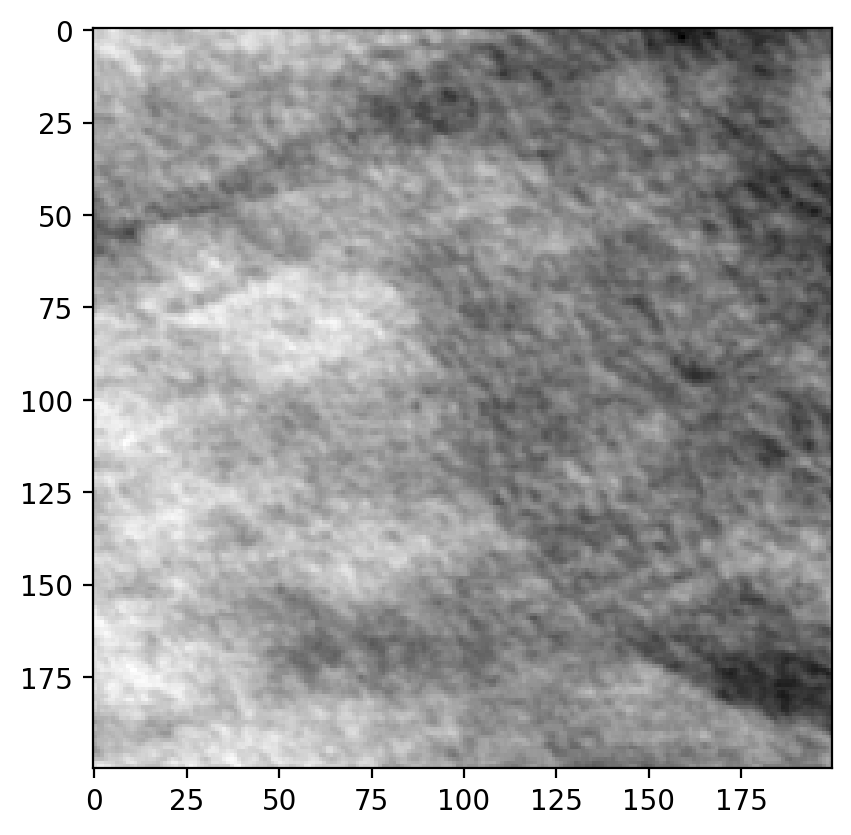

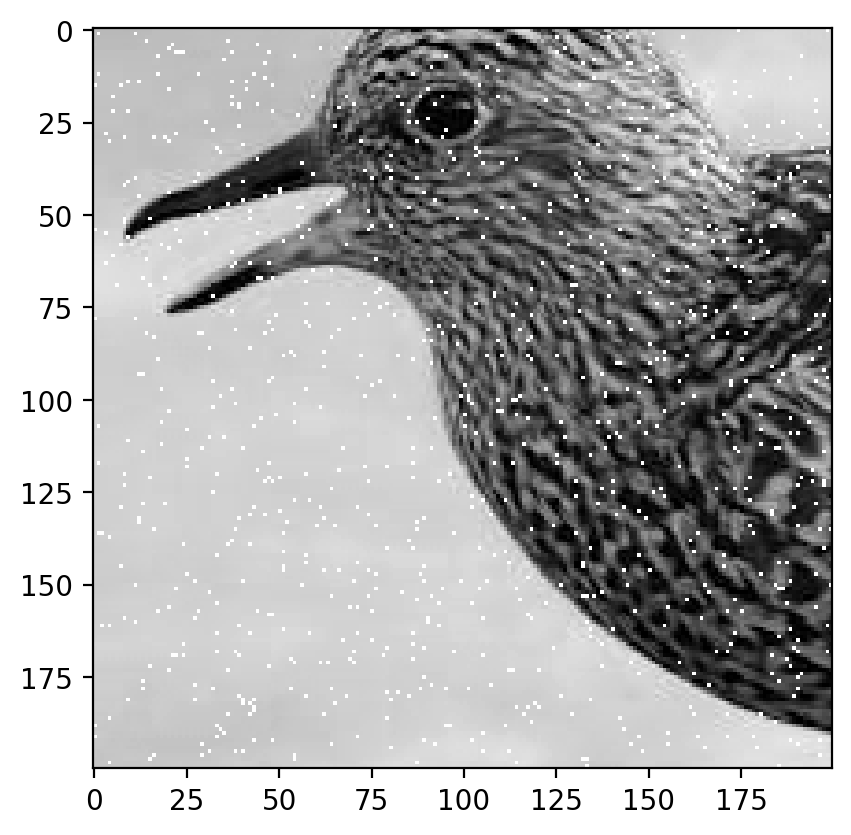

<function matplotlib.pyplot.show(close=None, block=None)>

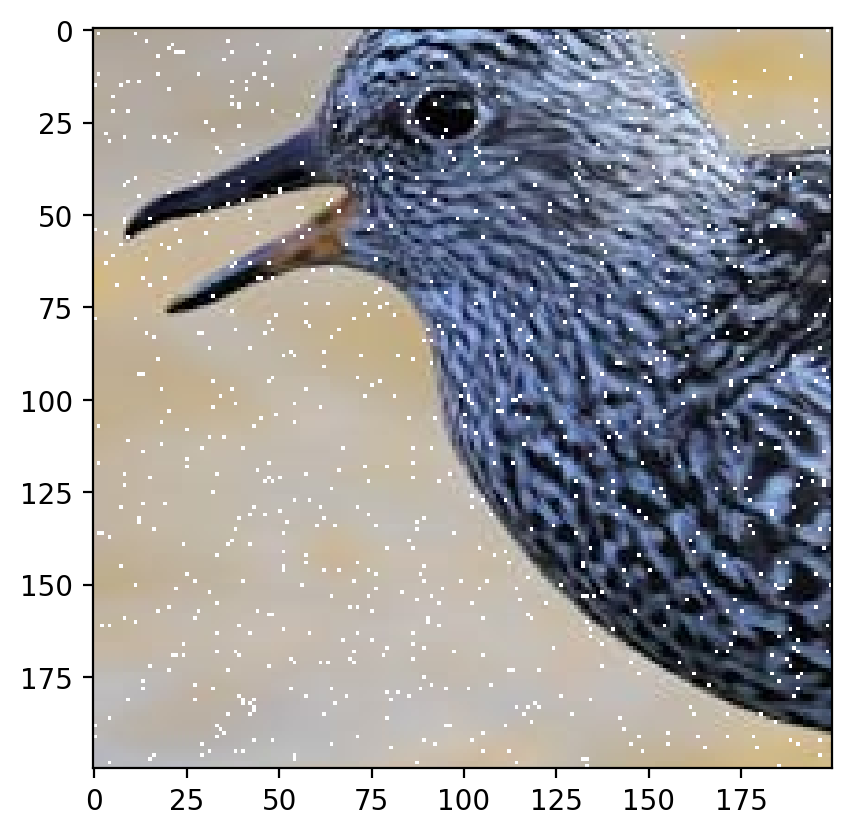

In [74]:
# pred_img_rff = np.stack([rff_r, rff_g, rff_b], axis=2).astype(np.uint8)
# print(pred_img_rff.shape)
plt.imshow(rff_r,cmap="gray")
plt.show()
plt.imshow(m_img[0],cmap="gray")
plt.show()
plt.imshow(m_img.permute(1, 2, 0).cpu().numpy() / 255)
plt.show

In [57]:
for i in range(10,50,5):
  w,h,loss = factorize(m_img_2[0],i,device)
  print(i, loss)

NameError: name 'm_img_2' is not defined

### I use rank = 25 after validating with other values (see above outputs)

In [25]:
w,h,loss = factorize(m_img_2[0],25,device)
loss

tensor(1.4944, grad_fn=<LinalgVectorNormBackward0>)

In [26]:
pred_img_m = torch.mm(w,h).cpu().detach().numpy()

# Using Random Fourier Features

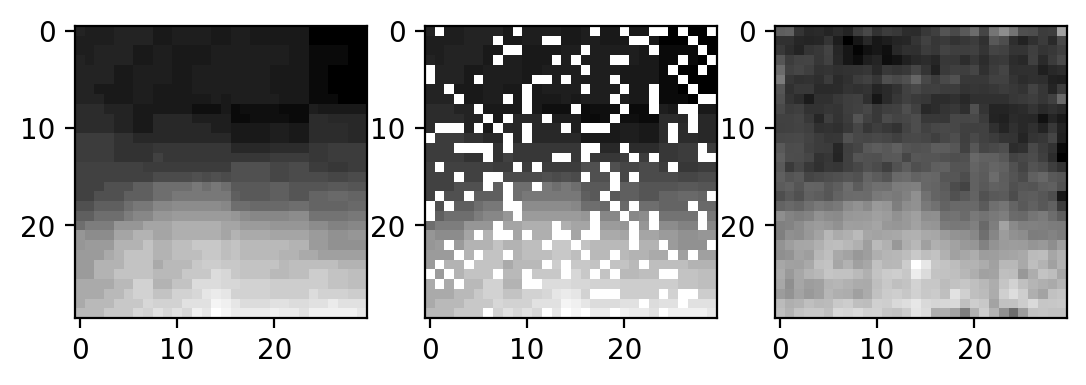

In [27]:
plt.tight_layout()

plt.subplot(1,3,1)
plt.imshow(c_img,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(m_img_2[0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(pred_img_rff,cmap='gray')


In [28]:
rmse_rff,psnr_rff = mse_psnr(c_img,pred_img_rff)
print(f"rmse: {rmse_rff} , psnr: {psnr_rff}")

rmse: 1.6116047939559672 , psnr: 43.98563259685507


# Using Matrix Factorisation

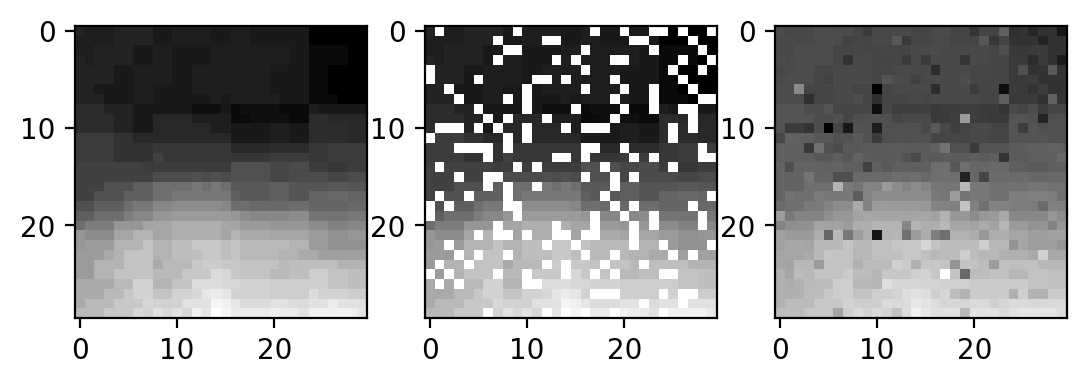

In [29]:
plt.tight_layout()

plt.subplot(1,3,1)
plt.imshow(c_img,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(m_img_2[0],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(pred_img_m,cmap='gray')

In [30]:
rmse_mf,psnr_mf = mse_psnr(c_img,pred_img_m)
print(f"rmse: {rmse_mf} , psnr: {psnr_mf}")


rmse: 1.2450766403477582 , psnr: 46.22688190605697


We can see that the Prediction using Matrix Factorisation is better than by using Random Fourier Features (RFF) and Linear Regression.
<br>
RMSE(Matrix Factorisation) < RMSE(RFF and Linear Regression)
<br>
PSNR(Matrix Factorisation) > PSNR(RFF and Linear Regression)